In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from display_xml import XML
import CLB.CLBXMLWriter as CLBXML   

# Datafile from 10.1029/2018WR024179

In [ ]:
! wget http://gems-ftp.yonsei.ac.kr/gitlab/taesup/dataset-stokes-brinkman-flow-simulation/-/archive/master/dataset-stokes-brinkman-flow-simulation-master.tar.gz
! tar -zxf dataset-stokes-brinkman-flow-simulation-master.tar.gz
! rm dataset-stokes-brinkman-flow-simulation-master.tar.gz

In [2]:
! mkdir -p r_packages
! echo 'install.packages("jpeg", repos="http://cran.r-project.org", lib="r_packages")' | /usr/bin/R --slave

trying URL 'http://cran.r-project.org/src/contrib/jpeg_0.1-9.tar.gz'
Content type 'application/x-gzip' length 18596 bytes (18 KB)
downloaded 18 KB

* installing *source* package 'jpeg' ...
** package 'jpeg' successfully unpacked and MD5 sums checked
** using staged installation
** libs
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-jbaK_j/r-base-3.6.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c read.c -o read.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-jbaK_j/r-base-3.6.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c reg.c -o reg.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-jbaK_j/r-base-3.6.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c write.c -o write.o
gcc -

In [12]:
bs1_sample = h5py.File('dataset-stokes-brinkman-flow-simulation-master/BS1/BS1-2_subset.h5')    

In [17]:
porous_block = bs1_sample['vox'][::10,::10,::10]


porous_block.shape

(40, 40, 40)

In [153]:
porous_block = bs1_sample['vox'][::10,::10,::10]
Ip = 2039
Is = 2107

porous_block = np.where(porous_block < Ip , 1, np.where(porous_block > Is, 0, (Is - porous_block)/(Is-Ip)))




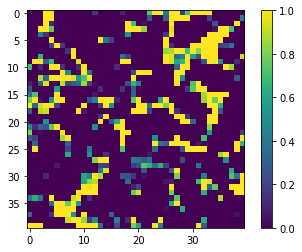

In [154]:
plt.imshow(porous_block[:,:,20])
plt.colorbar()

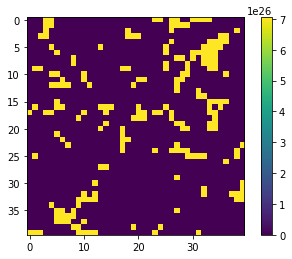

In [155]:
permability = porous_block**3 / (1-porous_block + 1E-15)**2 * 1. / 180 + 1E-10

plt.imshow(permability[:,:,20])
plt.clim(0,np.average(permability[:,:,20]))
plt.colorbar()

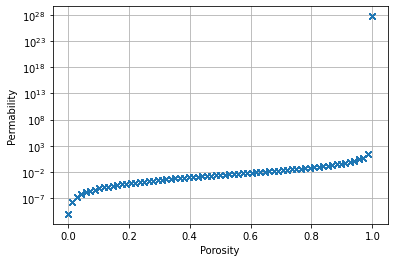

In [214]:
plt.semilogy(porous_block.ravel(), permability.ravel(), 'x')
plt.xlabel('Porosity')
plt.ylabel('Permability')
plt.grid(which='both')

In [157]:
init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(permability,order='C'))
init_binfile.close()

In [158]:
CLBc = CLBXML.CLBConfigWriter( )

dim = permability.shape

CLBc.addGeomParam('nx', dim[0])
CLBc.addGeomParam('ny', dim[1])
CLBc.addGeomParam('nz', dim[2])


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

params = {
        "Viscosity":1/6.,
        "ForceY":0.005,
        "Magic": 3/16.
}

CLBc.addModelParams(params)


CLBc.addRunR(eval=\
f"""
    con <- file("permability.bin", "rb")
    init <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)
    Solver$Fields$Permability[] = init;   
""")

CLBc.addHDF5()
time = 2000
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
#CLBc.addHDF5()

CLBc.write('StokesPermability.xml')

#f = open('AllenCahnTrapezoidal.xml', 'r')
#XML(''.join(f.readlines()))

! rm -rf ./output/StokesPermability* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 StokesPermability.xml 


MPMD: TCLB: local:0/1 work:0/1 ---  connected to:
[  ] -------------------------------------------------------------------------
[  ] -  CLB version:      v6.5.0-159-gd51ecfb3                               -
[  ] -        Model: auto_porous_media_d3q19_TRT_GinzburgEqOrd1                      
[  ]          -
[  ] -------------------------------------------------------------------------
[  ] Setting output path to: StokesPermability
[  ] Discarding 1 comments
[ 0] Running on CPU
[ 0] WARNING: No "Units" element in config file
[  ] Mesh size in config file: 40x40x40
[  ] Global lattice size: 40x40x40
[  ] Max region size: 64000. Mesh size 64000. Overhead:  0%
[  ] Local lattice size: 40x40x40
[  ]   Threads  |      Action
[  ]     1x1    | Primal , NoGlobals , BaseIteration
[  ]     1x1    | Tangent , NoGlobals , BaseIteration
[  ]     1x1    | Optimize , NoGlobals , BaseIteration
[  ]     1x1    | SteadyAdjoint , NoGlobals , BaseIteration
[  ]     1x1    | Primal , IntegrateGlobals , Ba

In [159]:
i = time

f = h5py.File('./output/StokesPermability_HDF5_%08d.h5'%i)    

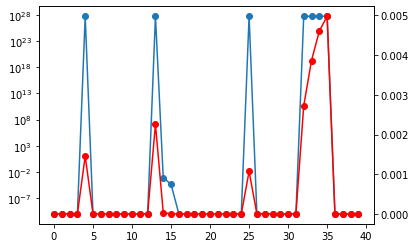

In [160]:
#plt.plot(permability[:,5,20], 'o-')
plt.semilogy(f['Permability'][5,:,20], 'o-')
plt.twinx()
plt.plot(f['U'][5,:,20,1], 'ro-')
#plt.plot(f['U'][5,:,20,0], 'ko-')
#plt.plot(f['U'][5,:,20,2], 'go-')

#plt.imshow(f['Permability'][0,:,:])

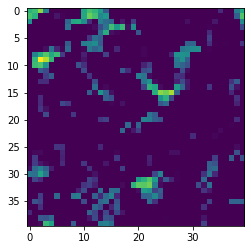

In [161]:
plt.imshow(f['U'][:,:,5,1])


In [162]:
shape = f['U'][20,:,:,1].shape

X,Y = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))

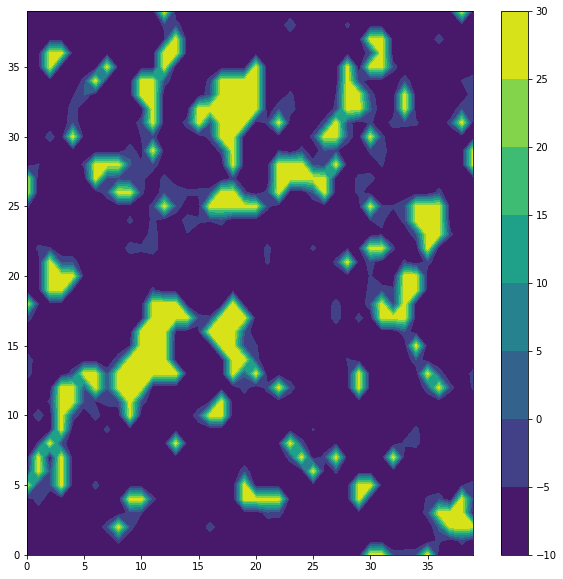

In [163]:
plt.figure(figsize=(10,10))
plt.contourf(X,Y,np.log10(f['Permability'][y0,:,:]))
#plt.clim(0, np.average(f['Permability'][y0,:,:]))
plt.colorbar()

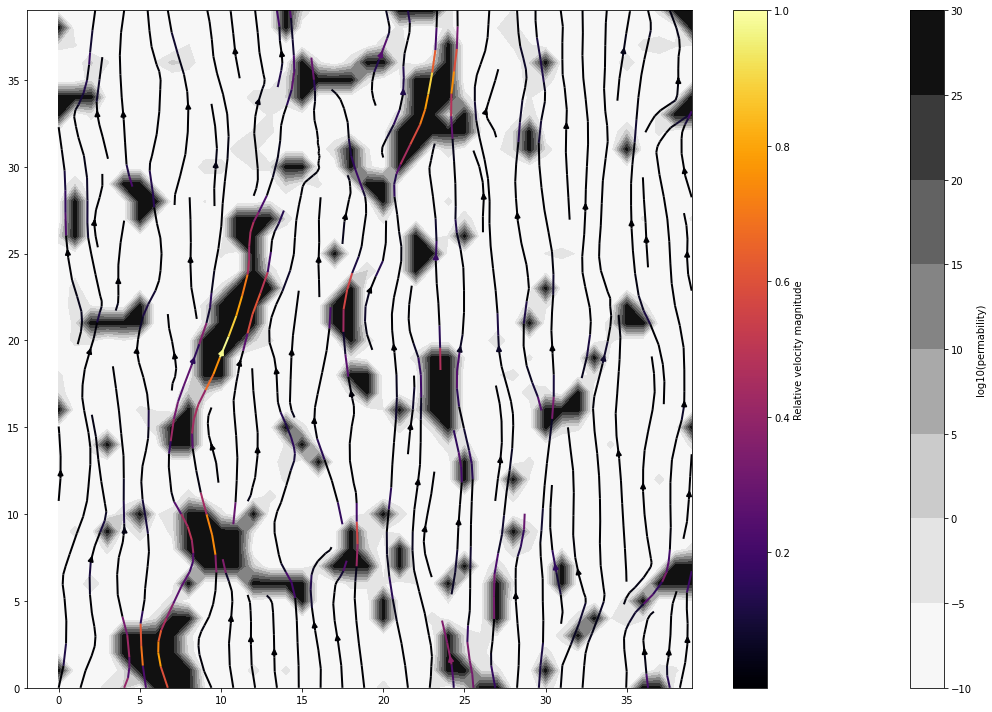

In [212]:
y0 = 10

plt.figure(figsize=(15,10))
plt.contourf(X,Y,np.log10(f['Permability'][y0,:,:]), cmap='Greys')


cb = plt.colorbar()
cb.ax.set_ylabel('log10(permability)')

speed = np.sqrt( f['U'][y0,:,:,0]**2  + f['U'][y0,:,:,1]**2 + f['U'][y0,:,:,2]**2 )
lw = speed / speed.max()





plt.streamplot(X,Y,f['U'][y0,::1,:,0],f['U'][y0,::1,:,1], density=1, color=lw, cmap='inferno', linewidth=2)

#cax = plt.gcf().add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar().ax.set_ylabel('Relative velocity magnitude')

ax.set_aspect('equal', 'box')
plt.tight_layout()